# 사용할 패키지

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob # 폴더 안에 파일들의 목록을 불러올 때 사용
from tqdm import tqdm # for문의 상태바를 나타내주는 tqdm라이브러리

import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Conv3D, ConvLSTM2D, BatchNormalization, Input, Dropout
from tensorflow.keras.optimizers import Adam

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# TPU 장치 설정

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On kaggle this is always the case.
    print('Running on TPU', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()
    # default distribution strategy in Tensorflow. Works on CPU and single GPU.
print("Replicas: ", strategy.num_replicas_in_sync)

Running on TPU grpc://10.77.239.138:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.77.239.138:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.77.239.138:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Replicas:  8


In [ ]:
path = '/content/drive/MyDrive/data/'

# **데이터 가져오기**

In [ ]:
train_csv = pd.read_csv(path+'train.csv')

In [ ]:
train_csv.head()

,month,file_nm
0,1978-11,197811.npy
1,1978-12,197812.npy
2,1979-01,197901.npy
3,1979-02,197902.npy
4,1979-03,197903.npy


1988년 1월에서 2017년 12월까지 30년 데이터를 학습하였습니다.

In [ ]:
train_path = sorted(glob(path+'train/*.npy'))     # glub : 폴더 안에 파일들의 목록을 불러올 때 사용
train_path = train_path[-31*12:-12]
train_path

['/content/drive/MyDrive/data/train/198801.npy',
 '/content/drive/MyDrive/data/train/198802.npy',
 '/content/drive/MyDrive/data/train/198803.npy',
 '/content/drive/MyDrive/data/train/198804.npy',
 '/content/drive/MyDrive/data/train/198805.npy',
 '/content/drive/MyDrive/data/train/198806.npy',
 '/content/drive/MyDrive/data/train/198807.npy',
 '/content/drive/MyDrive/data/train/198808.npy',
 '/content/drive/MyDrive/data/train/198809.npy',
 '/content/drive/MyDrive/data/train/198810.npy',
 '/content/drive/MyDrive/data/train/198811.npy',
 '/content/drive/MyDrive/data/train/198812.npy',
 '/content/drive/MyDrive/data/train/198901.npy',
 '/content/drive/MyDrive/data/train/198902.npy',
 '/content/drive/MyDrive/data/train/198903.npy',
 '/content/drive/MyDrive/data/train/198904.npy',
 '/content/drive/MyDrive/data/train/198905.npy',
 '/content/drive/MyDrive/data/train/198906.npy',
 '/content/drive/MyDrive/data/train/198907.npy',
 '/content/drive/MyDrive/data/train/198908.npy',
 '/content/drive/MyD

In [ ]:
train = []
for p in tqdm(train_path):     # for문의 상태바를 나타내주는 tqdm라이브러리
    train.append(np.load(p))
train = np.array(train)

100%|██████████| 360/360 [00:00<00:00, 484.84it/s]


In [ ]:
train.shape # 월마다 448row, 304column, 5depth의 데이터가 360개월치 존재

(360, 448, 304, 5)

# **데이터 시각화**

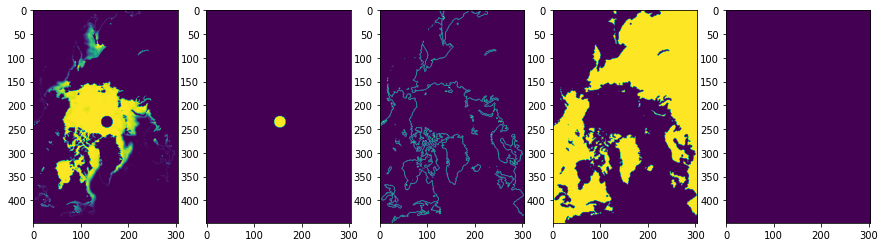

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(151)               # 1행 5열의 구조. 첫번째 그래프
plt.imshow(train[0,:,:,0])
plt.subplot(152)               # 1행 5열의 구조. 두번째 그래프
plt.imshow(train[0,:,:,1])
plt.subplot(153)               # 1행 5열의 구조. 세번째 그래프
plt.imshow(train[0,:,:,2])
plt.subplot(154)               # 1행 5열의 구조. 네번째 그래프
plt.imshow(train[0,:,:,3])
plt.subplot(155)               # 1행 5열의 구조. 다섯번째 그래프
plt.imshow(train[0,:,:,4])

# **사각 메우기**

In [ ]:
missings = pd.DataFrame()

for k in range(360) : 
  missings = pd.concat([missings,pd.DataFrame(train[k,:,:,4].reshape(-1,1))],ignore_index=True)

print(missings.min().min())
print(missings.max().max())

0
0


In [ ]:
train[0,:,:,0] + train[0,:,:,1]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
for k in range(360) :

  new_array = train[k,:,:,0] + train[k,:,:,1]*250
  train[k,:,:,0] = new_array

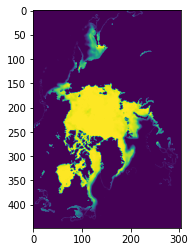

In [ ]:
plt.imshow(train[0,:,:,0])

# **월별 데이터로 분리**

In [ ]:
train_month = []
for i in range(12):
    train_month.append(train[i::12, :,:])
train_month = np.array(train_month)

In [ ]:
train_month.shape

(12, 30, 448, 304, 5)

# **이미지를 잘랐을 때 사이즈가 같도록 패딩**

In [ ]:
stride = 32
temp = np.zeros([train_month.shape[0],
                 train_month.shape[1],
                 train_month.shape[2]+(stride-train_month.shape[2]%stride),
                 train_month.shape[3]+(stride-train_month.shape[3]%stride),
                 train_month.shape[4]], np.uint8)
temp[:, :, :train_month.shape[2], :train_month.shape[3], :] = train_month     #이렇게 되면 480*320의 왼쪽 상단에는 패딩이 안된거 아닌가? 우측 하단 부분은 중요치 않아서 상관 없나?
train_month = temp
del temp

In [ ]:
train_month.shape

(12, 30, 480, 320, 5)

# **5년 단위로 데이터 전처리**

In [ ]:
window_size = 5

In [ ]:
x_train = []     # x_train = train_month[:, [0:5, 1:6,... 24:29], :, :, :] 앞에서부터 5년치씩 묶음
y_train = []     # y_train = train_month[:, [5:6, 6:7,... 29:30], :, :, :] 앞의 묶음 다음해

for i in range(train_month.shape[1]-window_size):
    x_train.append(train_month[:, i:i+window_size, :, :, :])
    y_train.append(train_month[:, i+window_size:i+window_size+1, :, :, :])

x_train = np.array(x_train)
y_train = np.array(y_train)

In [ ]:
x_train.shape, y_train.shape

((25, 12, 5, 480, 320, 5), (25, 12, 1, 480, 320, 5))

# **시각화**

특정 월의 5년간 변화와 그 다음 상태

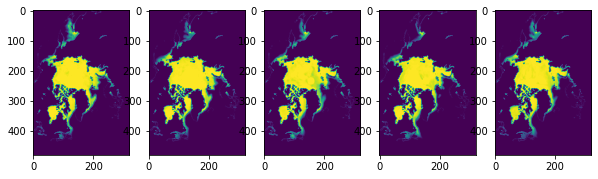

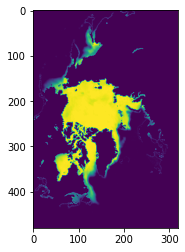

In [ ]:
m = 1     # 제일 처음 5년 중 각 해의 첫 달(데이터는 11월부터 시작)과 다음 해의 같은 달 시각화  
plt.figure(figsize=(10,15))
for y in range(x_train.shape[2]):
    plt.subplot(1,window_size,y+1)
    plt.imshow(x_train[0,m-1,y,:,:,0])
plt.show()

plt.imshow(y_train[0,m-1,-1,:,:,0])

# **데이터 자르기**

이미지가 클 경우 ConvLSTM모델의 메모리가 부족하여 가로세로 32px씩 이동하며 128x128로 이미지를 잘랐습니다.

학습에는 2017년까지, 2017년도를 평가 데이터로 활용하여 학습 결과를 2017년(가장 최근년도)에 과적합시켰습니다.

In [ ]:
#stride = 32
feature_size = 128
x_train_ = []
y_train_ = []
for y in range(x_train.shape[0]):
    for m in range(12):
        for i in range((x_train.shape[3]-feature_size)//stride+1):
            for j in range((x_train.shape[4]-feature_size)//stride+1):
                x_ = x_train[y, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, :1]
                y_ = y_train[y, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, :1]
                x_train_.append(x_)
                y_train_.append(y_)

x_train_ = np.array(x_train_)
y_train_ = np.array(y_train_)

x_val_ = []
y_val_ = []

for m in range(12):
    for i in range((x_train.shape[3]-feature_size)//stride+1):
        for j in range((x_train.shape[4]-feature_size)//stride+1):
            x_ = x_train[-1, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, :1]
            y_ = y_train[-1, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, :1]
            x_val_.append(x_)
            y_val_.append(y_)
            
x_val_ = np.array(x_val_)
y_val_ = np.array(y_val_)

In [ ]:
x_train_.shape, y_train_.shape, x_val_.shape, y_val_.shape

((25200, 5, 128, 128, 1),
 (25200, 1, 128, 128, 1),
 (1008, 5, 128, 128, 1),
 (1008, 1, 128, 128, 1))

# **데이터 시각화**

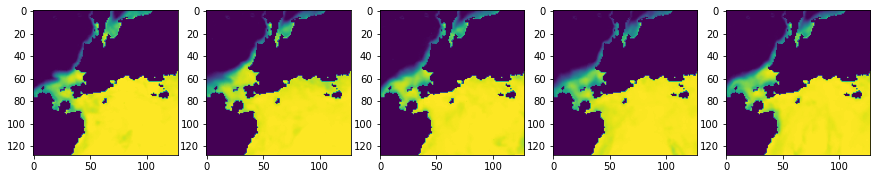

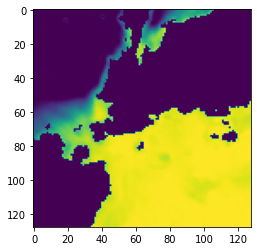

In [ ]:
i = 22
plt.figure(figsize=(15,10))
for y in range(x_train_.shape[1]):
    plt.subplot(1,window_size,y+1)
    plt.imshow(x_train_[i,y,:,:,0])
plt.show()
plt.imshow(y_train_[i,-1,:,:,0])

# **데이터셋**

In [ ]:
def train_map_func(x, y):
    x = tf.cast(x, tf.float32)/250
    y = tf.cast(y, tf.float32)
    return x, y

In [ ]:
BATCH_SIZE = 32

In [ ]:
# tf.data.Dataset.from_tensor_slices 함수는 tf.data.Dataset를 생성하는 함수로 입력된 텐서로부터 slices를 생성합니다.
# 예를 들어 MNIST의 학습데이터 (60000, 28, 28)가 입력되면, 60000개의 slices로 만들고 각각의 slice는 28×28의 이미지 크기를 갖게 됩니다.
# tf.data.Dataset.from_tensor_slices 함수에 return 받길 원하는 데이터를 튜플 (data, label) 형태로 넣어서 사용할 수 있습니다.

#  맵(map) 함수 : 리스트와 같은 시퀀스형 자료의 모든 원소에 동일한 연산/기능을 적용시킬 때 사용한다

# num_parallel_calls=tf.data.experimental.AUTOTUNE

# prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train_, y_train_))
train_dataset = train_dataset.map(train_map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val_, y_val_))
val_dataset = val_dataset.map(train_map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
next(iter(train_dataset))[0].shape, next(iter(train_dataset))[1].shape

(TensorShape([32, 5, 128, 128, 1]), TensorShape([32, 1, 128, 128, 1]))

In [ ]:
next(iter(val_dataset))[0].shape, next(iter(val_dataset))[1].shape

(TensorShape([32, 5, 128, 128, 1]), TensorShape([32, 1, 128, 128, 1]))

# 모델19(하이퍼 파라미터 수정)

optimizer : nadam / convLSTM(3겹) / filter 32/ activation = elu/ dropout: 0.1



In [ ]:
with strategy.scope():
    inputs=Input((None, x_train_.shape[2], x_train_.shape[3], 1))

    convLSTM = ConvLSTM2D(filters=32, kernel_size=3, padding='same', return_sequences=True)(inputs)
    convLSTM = BatchNormalization()(convLSTM)

    convLSTM = ConvLSTM2D(filters=32, kernel_size=3, padding='same', return_sequences=True)(convLSTM)
    convLSTM = BatchNormalization()(convLSTM)

    convLSTM = ConvLSTM2D(filters=32, kernel_size=3, padding='same', return_sequences=True)(convLSTM)
    convLSTM = BatchNormalization()(convLSTM)
    #convLSTM = Dropout(0.1)(convLSTM)

    outputs = Conv3D(filters=1, kernel_size=3, activation='elu', padding='same', data_format='channels_last')(convLSTM)

    model19 = Model(inputs, outputs)
    model19.compile(loss='mae', optimizer='nadam', metrics = ['mae'])
    
model19.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, None, 128, 128, 1 0         
_________________________________________________________________
conv_lst_m2d_12 (ConvLSTM2D) (None, None, 128, 128, 32 38144     
_________________________________________________________________
batch_normalization_12 (Batc (None, None, 128, 128, 32 128       
_________________________________________________________________
conv_lst_m2d_13 (ConvLSTM2D) (None, None, 128, 128, 32 73856     
_________________________________________________________________
batch_normalization_13 (Batc (None, None, 128, 128, 32 128       
_________________________________________________________________
conv_lst_m2d_14 (ConvLSTM2D) (None, None, 128, 128, 32 73856     
_________________________________________________________________
batch_normalization_14 (Batc (None, None, 128, 128, 32 128 

# **학습**

30epochs까지만 학습하였습니다.

In [ ]:
# 파일인지 디렉터리인지 확인
# os.path.isfile() : 인자가 입력된 경로가 파일일시 True, 아닐시 False 리턴
# os.path.isdir() : 인자가 입력된 경로가 디렉터리일시 True, 아닐시 False 리턴

if not (os.path.isdir('models')):
    os.makedirs('models')

callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath = './models/convlstm_model19.h5',
        monitor='val_loss',
        save_best_only=True
    )
]

hist19 = model19.fit(train_dataset, epochs=30, validation_data=val_dataset, callbacks=callbacks_list)

Epoch 1/30
788/788 [==============================] - 423s 504ms/step - loss: 24.0575 - mae: 24.0575 - val_loss: 8.8961 - val_mae: 8.8961
Epoch 2/30
788/788 [==============================] - 337s 428ms/step - loss: 8.2257 - mae: 8.2257 - val_loss: 6.4353 - val_mae: 6.4353
Epoch 3/30
788/788 [==============================] - 337s 428ms/step - loss: 7.0378 - mae: 7.0378 - val_loss: 5.9331 - val_mae: 5.9331
Epoch 4/30
788/788 [==============================] - 337s 428ms/step - loss: 6.4294 - mae: 6.4294 - val_loss: 6.9850 - val_mae: 6.9850
Epoch 5/30
788/788 [==============================] - 337s 428ms/step - loss: 6.1002 - mae: 6.1002 - val_loss: 5.6414 - val_mae: 5.6414
Epoch 6/30
788/788 [==============================] - 337s 428ms/step - loss: 5.9662 - mae: 5.9662 - val_loss: 5.6261 - val_mae: 5.6261
Epoch 7/30
788/788 [==============================] - 338s 428ms/step - loss: 5.8920 - mae: 5.8920 - val_loss: 5.6129 - val_mae: 5.6129
Epoch 8/30
788/788 [==========================

# **학습 결과**

In [ ]:
plt.plot(hist19.history['loss'][1:])
plt.plot(hist19.history['val_loss'][1:])
plt.show()

# **모델 불러오기**

In [ ]:
model19 = load_model('./models/convlstm_model19.h5')

# **검증셋 추론**

In [ ]:
pred = model19.predict(next(iter(val_dataset))[0])
pred = np.where(pred>250, 250, pred)

# **검증셋 추론 결과**

In [ ]:
for i in range(BATCH_SIZE):
    plt.subplot(141)
    plt.imshow(next(iter(val_dataset))[1][i,0,:,:,0])
    plt.subplot(142)
    plt.imshow(pred[i,0,:,:,0])
    plt.show()
    print(np.mean(np.abs(next(iter(val_dataset))[1][i,0,:,:,0] - pred[i,0,:,:,0])))

# **2018년 추론 데이터 전처리**
2015 ~ 2017년까지 5년간 월별 데이터를 학습과 같은 형태로 전처리

In [ ]:
x_test = train_month[:,-1*window_size:,:,:,:1]
x_test = np.swapaxes(x_test , 0, 1)

In [ ]:
x_test_ = []
for m in range(12):
    feature = []
    for i in range((x_train.shape[3]-feature_size)//stride+1):
        for j in range((x_train.shape[4]-feature_size)//stride+1):
            x_ = x_test[:, m, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, :1]/250
            feature.append(x_)
    feature = np.array(feature)
    x_test_.append(feature)
x_test_ = np.array(x_test_)

In [ ]:
x_test_.shape

# **추론**
각 월별 추론하여 저장

In [ ]:
preds = []
for m in tqdm(range(12)):
    pred = model19.predict(x_test_[m])
    pred = np.where(pred>250, 250, pred)
    preds.append(pred)

# **TTS**
추론 결과 중복된 영역의 경우 평균을 이용해 앙상블
stride값이 작을수록 앙상블에 의해 결과가 좋아지나 일정값 이상으로 작아지면 큰 효과가 없고 추론 시간이 기하급수적으로 늘어납니다.

In [ ]:
voting_mask = np.zeros((x_train.shape[-3], x_train.shape[-2]))
ones = np.ones((feature_size, feature_size))

for i in range((x_train.shape[3]-feature_size)//stride+1):
    for j in range((x_train.shape[4]-feature_size)//stride+1):
        voting_mask[stride*i:stride*i+feature_size, stride*j:stride*j+feature_size] += ones

평균 계산용 마스크

In [ ]:
plt.imshow(voting_mask)

In [ ]:
results = []
for m in range(12):
    pred = np.zeros((x_train.shape[-3], x_train.shape[-2]))
    k = 0
    for i in range((x_train.shape[3]-feature_size)//stride+1):
        for j in range((x_train.shape[4]-feature_size)//stride+1):
            pred[stride*i:stride*i+feature_size, stride*j:stride*j+feature_size] += preds[m][k,-1,:,:,0]
            k+=1
    pred /= voting_mask
    results.append(pred[:448, :304])
results = np.array(results)

# **추론 결과**

In [ ]:
for m in range(12):
    plt.imshow(results[m])
    plt.show()
    print(m+1, '\n')